In [1]:
import dgl
import dgl.function as fn
import torch
import torch.nn as nn
import networkx as nx
import torch.nn.functional as F

%matplotlib inline
import networkx as nx

import os

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
class SAGEConv(nn.Module):
    def __init__(self, in_feats, out_feats):
        super(SAGEConv, self).__init__()
        self.linear = nn.Linear(in_feats * 2, out_feats)

    def forward(self, g, h):
        """
        g: graph object
        h: node feature [batchsize,dimension]
        """
        with g.local_scope():
            g.ndata["h"] = h
            g.update_all(fn.copy_u("h", "h_N"), fn.mean("h_N", "h_N"))
            h_N = g.ndata["h_N"]
            h_cat = torch.cat([h, h_N], dim=1)

            return self.linear(h_cat)

In [3]:
class Model(nn.Module):
    def __init__(self, in_feats, h_feats, out_feats):
        super().__init__()
        self.conv1 = SAGEConv(in_feats, h_feats)
        self.conv2 = SAGEConv(h_feats, out_feats)

    def forward(self, g, h):
        h = self.conv1(g, h)
        h = F.relu(h)
        return self.conv2(g, h)

In [4]:
dataset = dgl.data.CoraGraphDataset("./")

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


In [5]:
g = dataset[0]
idx = torch.randint(0, 1000, (50,))
sg1 = g.edge_subgraph(idx)

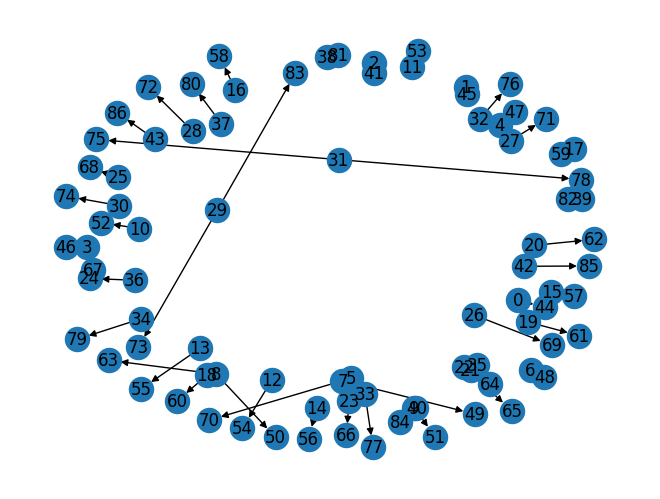

In [6]:
nx.draw(dgl.to_networkx(sg1), with_labels=True)

In [7]:
# writer_train.close()
# writer_test.close()
# writer_val.close()

In [8]:
from tensorboardX import SummaryWriter

writer_train = SummaryWriter("./records/cora_graphSAGE/train")
writer_test = SummaryWriter("./records/cora_graphSAGE/test")
writer_val = SummaryWriter("./records/cora_graphSAGE/val")

n_epochs = 0


def train(g, model, epochs=20):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    features = g.ndata["feat"]
    labels = g.ndata["label"]
    train_mask = g.ndata["train_mask"]
    val_mask = g.ndata["val_mask"]
    test_mask = g.ndata["test_mask"]

    for e in range(epochs):
        logits = model(g, features)
        pred = logits.argmax(1)

        loss = F.cross_entropy(logits[train_mask], labels[train_mask])

        with torch.no_grad():
            train_acc = (pred[train_mask] == labels[train_mask]).float().mean()
            test_acc = (pred[test_mask] == labels[test_mask]).float().mean()
            val_acc = (pred[val_mask] == labels[val_mask]).float().mean()

            writer_test.add_scalar("acc", test_acc, e)
            writer_train.add_scalar("acc", train_acc, e)
            writer_val.add_scalar("acc", val_acc, e)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if e % 10 == 0:
            print(
                f"epoch: {e}, loss: {loss}, train acc: {train_acc}, test acc:{test_acc}  "
            )

    writer_test.close()
    writer_train.close()
    writer_val.close()

In [9]:
n_feats = g.ndata["feat"].shape[1]
n_labels = torch.unique(g.ndata["label"]).max() + 1
device = "cuda" if torch.cuda.is_available() else "cpu"

model = Model(n_feats, n_feats * 2, n_labels).to(device)
g = g.to(device)

In [10]:
train(g, model, 100)

epoch: 0, loss: 1.9459112882614136, train acc: 0.1428571492433548, test acc:0.10600000619888306  
epoch: 10, loss: 0.00014965891023166478, train acc: 1.0, test acc:0.7860000133514404  
epoch: 20, loss: 1.2261465087703982e-07, train acc: 1.0, test acc:0.7910000085830688  
epoch: 30, loss: 5.108968359479604e-09, train acc: 1.0, test acc:0.7910000085830688  
epoch: 40, loss: 1.7029896381970389e-09, train acc: 1.0, test acc:0.7920000553131104  
epoch: 50, loss: 8.514948746096707e-10, train acc: 1.0, test acc:0.7920000553131104  
epoch: 60, loss: 8.514948746096707e-10, train acc: 1.0, test acc:0.7920000553131104  
epoch: 70, loss: 8.514948746096707e-10, train acc: 1.0, test acc:0.7920000553131104  
epoch: 80, loss: 8.514948746096707e-10, train acc: 1.0, test acc:0.7920000553131104  
epoch: 90, loss: 8.514948746096707e-10, train acc: 1.0, test acc:0.7920000553131104  


In [81]:
class WeightedSAGEConv(nn.Module):
    def __init__(self, in_feats, out_feats):
        super(WeightedSAGEConv, self).__init__()
        self.linear = nn.Linear(in_feats * 2, out_feats)

    def forward(self, g, h, w):
        """
        w: the edge weight
        """
        with g.local_scope():
            g.ndata["h"] = h
            g.edata["w"] = w
            g.update_all(
                message_func=fn.u_mul_e("h", "w", "m"),
                reduce_func=fn.mean("m", "h_N"),
            )
            h_N = g.ndata["h_N"]
            h_cat = torch.cat([h, h_N], dim=1)
            return self.linear(h_cat)

In [82]:
class Model_weight(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super(Model_weight, self).__init__()
        self.conv1 = WeightedSAGEConv(in_feats, h_feats)
        self.conv2 = WeightedSAGEConv(h_feats, num_classes)

    def forward(self, g,in_feat):
        h = self.conv1(g, in_feat, torch.ones(g.num_edges(), 1).to(g.device))
        h = F.relu(h)
        h = self.conv2(g, h, torch.ones(g.num_edges(), 1).to(g.device))
        return h

In [83]:
writer_train = SummaryWriter("./records/cora_graphSAGE_weight/train")
writer_test = SummaryWriter("./records/cora_graphSAGE_weight/test")
writer_val = SummaryWriter("./records/cora_graphSAGE_weight/val")

In [84]:
n_feats = g.ndata["feat"].shape[1]
n_labels = torch.unique(g.ndata["label"]).max() + 1
device = "cuda" if torch.cuda.is_available() else "cpu"

model_weight = Model_weight(n_feats, n_feats, n_labels).to(device)

In [86]:
train(g, model_weight, 100)

epoch: 0, loss: 9.366440067992698e-09, train acc: 1.0, test acc:0.7800000309944153  
epoch: 10, loss: 8.514948746096707e-10, train acc: 1.0, test acc:0.7730000615119934  
epoch: 20, loss: 0.0, train acc: 1.0, test acc:0.7780000567436218  
epoch: 30, loss: 0.0, train acc: 1.0, test acc:0.7800000309944153  
epoch: 40, loss: 0.0, train acc: 1.0, test acc:0.7770000100135803  
epoch: 50, loss: 0.0, train acc: 1.0, test acc:0.7780000567436218  
epoch: 60, loss: 0.0, train acc: 1.0, test acc:0.7780000567436218  
epoch: 70, loss: 0.0, train acc: 1.0, test acc:0.7770000100135803  
epoch: 80, loss: 0.0, train acc: 1.0, test acc:0.7770000100135803  
epoch: 90, loss: 0.0, train acc: 1.0, test acc:0.7760000228881836  
